In [103]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [104]:
import numpy as np
import pandas as pd
import datetime as dt
from dateutil.relativedelta import relativedelta

In [105]:
# Import the Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, text, func

# Reflect Tables into SQLAlchemy ORM

In [106]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [107]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)


In [108]:
# View all of the classes that automap found
Base.classes.keys()


['measurement', 'station']

In [109]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station


In [110]:
# Create our session (link) from Python to the DB
session = Session(engine)


# Exploratory Precipitation Analysis

In [111]:
# Find the most recent date in the data set.
most_recent_date_measurement = session.query(measurement).order_by(measurement.date.desc()).first()
print(most_recent_date_measurement.date)


2017-08-23


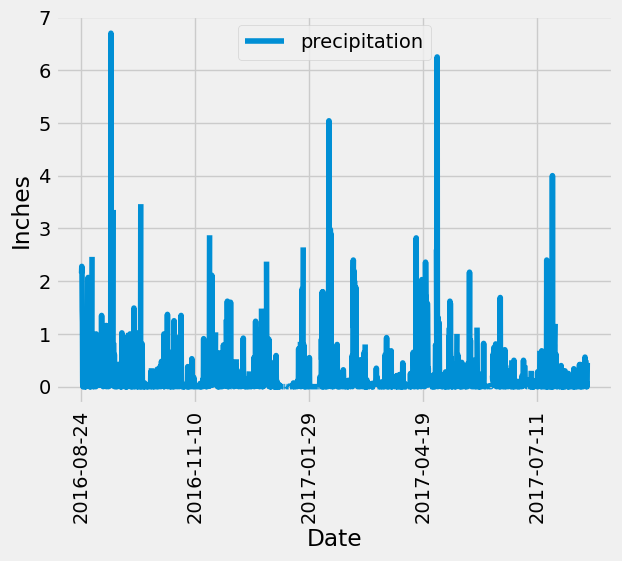

In [112]:
# date format for query
format = '%Y-%m-%d'

# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
# Perform a query to retrieve the data and precipitation scores
# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.read_sql_query(
    session.query(measurement.date, measurement.prcp).filter(measurement.date >= 
    dt.datetime.strptime(session.query(measurement).order_by(measurement.date.desc()).first().date, format) - relativedelta(years = 1)).statement
    ,con=engine)

# Sort the dataframe by date
df.sort_values(['date'], inplace=True)

df.rename(columns = {"prcp": "precipitation"}, inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
ax = df.plot(x="date", y="precipitation", rot=90, xlabel="Date", ylabel="Inches")


In [113]:
# Use Pandas to calculate the summary statistics for the precipitation data
df.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [114]:
# Design a query to calculate the total number of stations in the dataset
number_stations = session.query(station).count()
number_stations


9

In [115]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

# SQL query using groupby and count function
query = sqlalchemy.select([
    measurement.station,
    sqlalchemy.func.count(measurement.station)
]).group_by(measurement.station).order_by(sqlalchemy.func.count(measurement.station).desc())
 
# get all the records
result = engine.execute(query).fetchall()
 
# print all the records
for i in result:
    print(i)


('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [116]:
# Find which station id has the greatest number of observations
station_high = result[0][0]
print(station_high)



USC00519281


In [117]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

sel = [func.min(measurement.tobs), 
       func.max(measurement.tobs), 
       func.avg(measurement.tobs)]
result2 = session.query(*sel).\
    filter(measurement.station == station_high).\
    group_by(measurement.station).\
    order_by(measurement.station).all()
result2


[(54.0, 85.0, 71.66378066378067)]

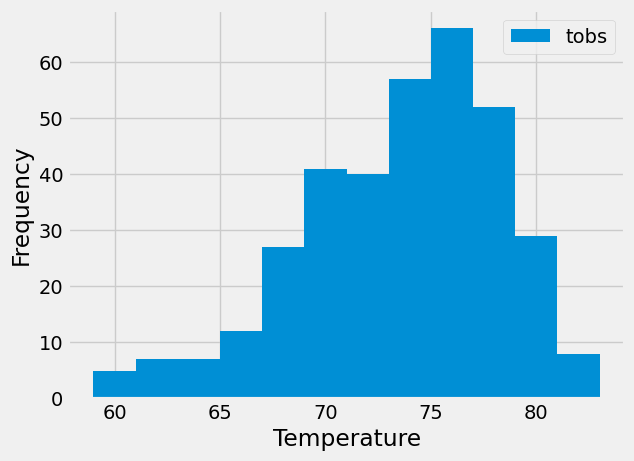

In [118]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

df2 = pd.read_sql_query(
    session.query(measurement.tobs)
    .filter(measurement.date >= dt.datetime.strptime(session.query(measurement).order_by(measurement.date.desc()).first().date, format) - relativedelta(years = 1))
    .filter(measurement.station == station_high)
    .statement
    ,con=engine)

plt.hist(df2, bins=12, label="tobs")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.legend()
plt.show()



# Close Session

In [119]:
# Close Session
session.close()